## Raiders of the pottery GAN
### Usando Redes Generativas Adversarias para generación sintética de modelos 3D de materiales en arqueología

Los restos cerámicos proporcionan valiosa información que ayuda a datar el estrato arqueológico donde se encuentran, aportando <font color=violet>evidencias</font> de la producción local, relaciones comerciales, comportamiento de consumidores en poblaciones locales, etc. [1, 2]\cite{Orton93, Kampel2003}.

La <font color=violet>fragilidad de la cerámica</font> hace que la mayor parte del material recuperado en un yacimiento arqueológico no se corresponda con piezas completas por lo que la  <font color=violet>gran mayoría</font> del material disponible está  <font color=violet>fragmentado</font>.

<div style="text-align:center"><img src="https://media.giphy.com/media/uA147Pq6OvgCA/giphy.gif" /></div>

La colección está formada por <font color=violet>vasijas cerámicas de torno</font> encontradas en diversos yacimientos arqueológicos ibéricos ubicados en el Valle del Alto Gualquivir (España).

<div style="text-align:center"><img src="https://raw.githubusercontent.com/celiacintas/vasijas/master/imagenes/dataset.png" width="400"/></div>



Está compuesta por unos miles de distintos recipientes, de los que se han registrado y clasificado <font color=violet>sus perfiles 2D proyectados</font> (vista lateral de cada una de ellas). La clasificación fue hecha en base a <font color=violet>criterios morfológicos</font> por un grupo de expertos~\cite{LucenaMTAP2014}.

## ¿Cómo generamos nuevas muestras 3D? 

<div style="text-align:center"><img src="https://raw.githubusercontent.com/celiacintas/vasijas/master/imagenes/augmentation_w.png"/></div>



## ¿Qué bibliotecas de Python usamos para implementar nuestros experimentos?


<div style="text-align:center"><img src="https://media.giphy.com/media/JDmIrA84Pw1hK/giphy.gif" /></div>

In [ ]:
#import trimesh, matplotlib, numpy, torch ... 
import 

## Qué es entrenamiento adversario?

\begin{equation}
\min_{\text{roca}}\max_{\text{indiana}} V(\text{indiana}, \text{roca}) = \text{distancia entre ellos}
\end{equation}


<div style="text-align:center"><img src="https://media.giphy.com/media/UVqDh08BFyGfrx9tRU/giphy.gif" width=300/></div>

<div style="text-align:center"><img src="https://raw.githubusercontent.com/celiacintas/vasijas//master/imagenes/overview.png" /></div>


Imagen de \cite{DBLP:journals/corr/abs-1710-07035}


### Algunas notaciones básicas

- $x$ es un <font color=violet>elemento de nuestro dataset </font> (<img src="https://raw.githubusercontent.com/celiacintas/vasijas/master/imagenes/amphora_1f3fa.png"  width=20/>).
- $D(x)$ es la salida de la red evaluadora (<img src="https://raw.githubusercontent.com/celiacintas/vasijas/master/imagenes/detective.png"  width=20/>), que nos devuelve <font color=violet>la probabilidad</font> de que $x$ sea real (<img src="https://raw.githubusercontent.com/celiacintas/vasijas/master/imagenes/amphora_1f3fa.png"  width=20/>) o generado (<img src="https://raw.githubusercontent.com/celiacintas/vasijas/master/imagenes/robot-face_1f916.png"  width=20/>) . $D(x)$ debería ser un valor alto cuando $x$ proviene de los datos de entrenamiento y bajo cuando $x$ es salida del generador.
- $z$ es <font color=violet>el vector del espacio latente</font> muestreado sobre una distribución normal. $G(z)$ representa la función del generador (<img src="https://raw.githubusercontent.com/celiacintas/vasijas/master/imagenes/robot-face_1f916.png"  width=20/>) que mapea el vector $z$ sobre el espacio de nuestros datos. 
- $D(G(z))$ es la probabilidad que la salida del generador sea un elemento real. $D$ trata de <font color=violet>maximizar la probabilidad</font> de clasificar correctamente elementos reales y falsos ($\log D(x)$), y $G$ trata de <font color=violet> minimizar la probabilidad </font> de que $D$ clasifique sus elementos generados como falsos $(\log (1 - D(G(x))$)


### Cómo cargamos nuestros datos?

In [13]:
from torchvision import datasets
from torchvision import transforms as tfs
import torchvision
from torch.utils import data

Torchvision provee formas sencillas para cargar datasets en formato necesario para ser consumido por una red en PyTorch. Ademas de cargar elementos existentes, cuenta con funciones de transformaciones basicas (afines:rotacion, traslacion, escala, etc) para aumentar artificialmente nuestro dataset.


In [16]:
imagenet_data = datasets.ImageFolder('../../../../vasijas/data/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                                                           tfs.Resize((16, 16)),
                                                           tfs.Grayscale(1),
                                                           tfs.ToTensor()]))

data_loader = data.DataLoader(imagenet_data, batch_size=16, shuffle=True)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

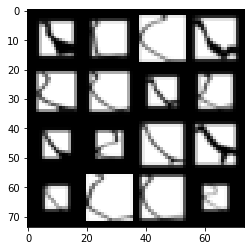

In [17]:
dataiter = iter(data_loader)
images = dataiter.next()

# show images
plt.imshow(torchvision.utils.make_grid(images[0], nrow=4).permute(1, 2, 0))

### Cómo Definimos la red Generadora y Evaluadora?

In [18]:
%%writefile generadora.py
class _G(nn.Module):
    """Clase Generadora
       input_dim: tamaño del vector latente.
       """
    def __init__(self, input_h_w=28, latent_v=62):
        super(_G, self).__init__()
        self.input_height = input_h_w
        self.input_width = input_h_w
        self.input_dim = latent_v
        self.output_dim = 1

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )
        # utils.initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)

        return x

Writing generadora.py


In [19]:
%%writefile evaluadora.py
from torch import nn
from utils import utils

class _D(nn.Module):
    """ Clase evaluadora
    TODO definir parametros"""
    def __init__(self, input_h_w=28):
        super(_D, self).__init__()     
        self.input_height = input_h_w
        self.input_width = input_h_w
        self.input_dim = 1
        self.output_dim = 1
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        # utils.initialize_weights(self)

    def forward(self, input_):
        x = self.conv(input_)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)

        return x

Writing evaluadora.py


### Cómo entrenamos estas dos redes?

<img src="https://raw.githubusercontent.com/celiacintas/vasijas/master/imagenes/GAN_epochs.gif" width=200/>


### Definiendo función de optimización y error

todo add brief description of both

In [ ]:
G = _G(input_h_w, latent_v)
D = _D(input_h_w)
G_optimizer = optim.Adam(G.parameters(),
                                      lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(),
                                      lr=0.0002, betas=(0.5, 0.999))
BCE_loss = nn.BCELoss()

In [ ]:
y_real_, y_fake_ = Variable(torch.ones(self.batch_size, 1)), \
                   Variable(torch.zeros(self.batch_size, 1))

In [ ]:
for epoch in range(epoch):
    G.train()
    for iter,  (x_, _) in enumerate(data_loader):
        # print("esta es la forma de mi batch,", x_.shape)
        if iter == data_loader.dataset.__len__() // batch_size:
            break
        
        z_ = torch.rand((batch_size, z_dim))
        x_, z_ = Variable(x_), Variable(z_)

        # update D network
        D_optimizer.zero_grad()

        D_real = D(x_)
        D_real_loss = BCE_loss(D_real, y_real_)

        G_ = G(z_)
        D_fake = D(G_)
        D_fake_loss = BCE_loss(D_fake, y_fake_)

        D_loss = D_real_loss + D_fake_loss
        train_hist['D_loss'].append(D_loss.data[0])

        D_loss.backward()
        D_optimizer.step()

        # update G network
        G_optimizer.zero_grad()

        G_ = G(z_)
        D_fake = D(G_)
        G_loss = BCE_loss(D_fake, y_real_)
        train_hist['G_loss'].append(G_loss.data[0])

        G_loss.backward()
        G_optimizer.step()